### Imports

In [1]:
# 0

#- try visualising all observations on a 2D or 3D chart (for 2 or 3 components), 
# using axis names as given by the LLM. Different color for the different clusters
# - prepare a storytelling presentation for one chosen scenario - 
# data overview, choice of data, preprocessing methods, PCA, LLM, business results, insights & recommendations

# Data wrangling
import pandas as pd
import numpy as np
from pathlib import Path
import re
from collections import defaultdict

# Modelling & preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Visualisation
import matplotlib.pyplot as plt

# OpenAI for auto-interpretation
import openai
import json
import keys       
from openai import OpenAI                

openai.api_key = keys.api_key   

# Misc
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import os




from collections import Counter
df_all = pd.read_excel("data_processed/survey_dataframe.xlsx", engine="openpyxl")

print("✅  Core libraries imported and OpenAI ready.")


✅  Core libraries imported and OpenAI ready.


### Load Survey Dataframe

In [2]:
# Cell 1 – Load processed survey dataframe

# Adjust ROOT if your notebook isn’t already inside Insights-First-Attempt
ROOT = Path.cwd()                # current working dir of notebook
DATA_FILE = ROOT / "data_processed" / "survey_dataframe.xlsx"

df = pd.read_excel(DATA_FILE, engine="openpyxl")

rows, cols = df.shape
print(f"✅ Loaded survey_dataframe.xlsx  →  {rows:,} rows × {cols} columns")
display(df.head())


✅ Loaded survey_dataframe.xlsx  →  2,055 rows × 456 columns


,SurveyInstanceID,358573_1,360190_1,360190_2,369184_1,369184_2,369184_3,369188_1,369188_2,369188_3,...,405564_2,405580_8,405581_6,405979_7,405980_7,405981_6,405982_6,405983_6,406171_9,406181_4
0,3005492,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3005493,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3005494,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3005495,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3005496,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute PCA Coordinates

In [3]:
# # Cell 2 – Compute fresh non-Likert PCA coordinates (always run)
# # ---------------------------------------------------------------------------
# from pathlib import Path
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # 1️⃣  Define the Likert IDs we want to EXCLUDE here
# LIKERT_BASE_IDS = [
#     '391222','383198','383199','391201','391213','380319',
#     '380514','405548','383195','380437','397317','380448',
#     '380442','405583','405568','405978'
# ]
# likert_cols = [f"{bid}_{opt}" for bid in LIKERT_BASE_IDS for opt in range(1,6)]

# # 2️⃣  Pick every remaining numeric column (except the ID)
# feature_cols = (
#     df.select_dtypes(include=[np.number])
#       .columns
#       .drop(['SurveyInstanceId'], errors='ignore')
#       .difference(likert_cols)                 # ← exclude Likert dummies
# )

# print(f"Using {len(feature_cols)} non-Likert numeric features")

# # 3️⃣  Standard-scale  ➜  PCA (3 comps)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df[feature_cols])

# pca = PCA(n_components=3, random_state=42)
# df[['PC1','PC2','PC3']] = pca.fit_transform(X_scaled)

# print("✅  PCA computed. Variance explained:", pca.explained_variance_ratio_.round(3))
# display(df[['PC1','PC2','PC3']].head())

# # 4️⃣  (Optional) save for reproducibility
# Path("Task2_output").mkdir(exist_ok=True)
# df[['PC1','PC2','PC3']].to_csv("Task2_output/pca_coordinates_NONLIKERT.csv")


In [4]:
# Cell 2b – Recompute PCA on the *16* Likert questions only
# ---------------------------------------------------------------------------
from pathlib import Path
import pandas as pd
from sklearn.decomposition import PCA

# --- 1. Load the 0–1-scaled Likert matrix -----------------------------------
LIKERT_PATH = Path("data_processed") / "likert_scaled_matrix.xlsx"
likert_raw  = pd.read_excel(LIKERT_PATH, engine="openpyxl")

# --- 2. Keep exactly the 16 confirmed Likert bases --------------------------
LIKERT_BASE_IDS = [
    #'391222', 
    #'383198', 
    #'383199', 
    #'391201', 
    #'391213', 
    #'380319',
    '380514', 
    '405548', 
    '383195', 
    '380437', 
    #'397317', 
    '380448',
    #'380442', 
    #'405583', 
    '405568', 
    #'405978' #maybe comment out
]

likert_feat = likert_raw[LIKERT_BASE_IDS].copy()
print("Likert matrix shape (16 cols expected):", likert_feat.shape)

# --- 3. PCA (3 components) --------------------------------------------------
pca = PCA(n_components=3, random_state=42)
pcs = pca.fit_transform(likert_feat.values)

pcs_df = pd.DataFrame(
    pcs, index=likert_feat.index, columns=["PC1", "PC2", "PC3"]
)

print("✅ PCA finished – variance explained:", pca.explained_variance_ratio_.round(3))

# --- 4. Merge PCs into the main dataframe ----------------------------------
df = df.drop(columns=["PC1", "PC2", "PC3"], errors="ignore")  # remove any prior PCs
df = df.join(pcs_df)

display(df[["PC1", "PC2", "PC3"]].head())


Likert matrix shape (16 cols expected): (2055, 6)
✅ PCA finished – variance explained: [0.752 0.097 0.049]


,PC1,PC2,PC3
0,-0.263181,-0.072584,-0.046902
1,1.984562,0.130728,0.016453
2,-0.303165,0.193324,0.002664
3,0.254701,0.054390,-0.047967
4,-0.364415,-0.048769,-0.006718


### K-means Clustering

In [5]:
# Cell 3 – K-means clustering on the three PCs


k = 4                      # tweak if you want more / fewer segments
kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init="auto"
)

df["cluster"] = kmeans.fit_predict(df[["PC1", "PC2", "PC3"]])

# quick check: how many rows in each cluster?
cluster_sizes = df["cluster"].value_counts().sort_index()
print("✅ Cluster sizes:")
display(cluster_sizes)


✅ Cluster sizes:


cluster
0      88
1    1321
2     190
3     456
Name: count, dtype: int64

### Graph Clusters

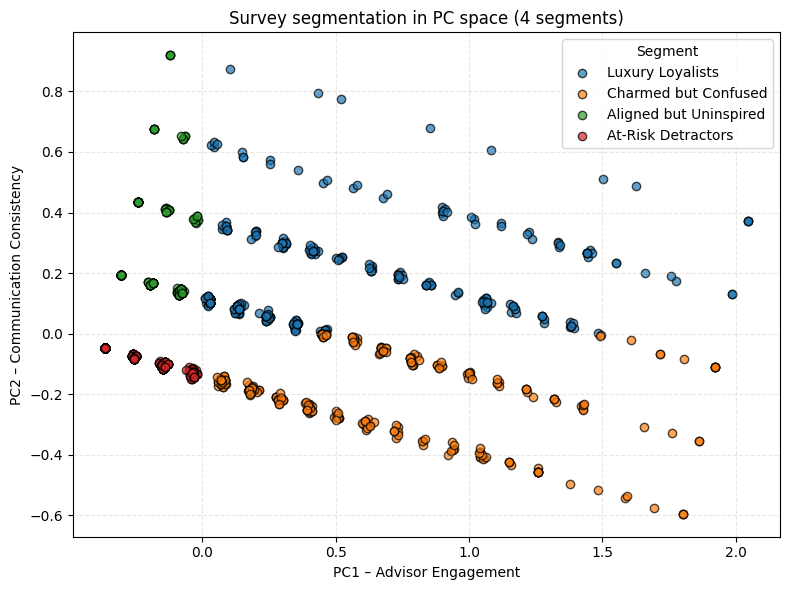

In [ ]:
# Cell 4 – Visualise 4 segments (quadrants of PC1 × PC2)
import matplotlib.pyplot as plt
import numpy as np

# 1. Define quadrant‐to‐label mapping
conditions = [
    (df["PC1"] >= 0) & (df["PC2"] >= 0),  # Q1: High PC1 & High PC2
    (df["PC1"] >= 0) & (df["PC2"] <  0),  # Q2: High PC1 & Low  PC2
    (df["PC1"] <  0) & (df["PC2"] >= 0),  # Q3: Low  PC1 & High PC2
    (df["PC1"] <  0) & (df["PC2"] <  0),  # Q4: Low  PC1 & Low  PC2
]
labels = [
    "Luxury Loyalists",
    "Charmed but Confused",
    "Aligned but Uninspired",
    "At-Risk Detractors",
]

# 2. Assign segment (use string default so dtype stays object)
df["segment"] = np.select(conditions, labels, default="")

# 3. Color palette for the four segments
palette = {
    "Luxury Loyalists":        "#1f77b4",
    "Charmed but Confused":    "#ff7f0e",
    "Aligned but Uninspired":       "#2ca02c",
    "At-Risk Detractors":          "#d62728",
}

# 4. Plot
fig, ax = plt.subplots(figsize=(8, 6))

for seg, color in palette.items():
    subset = df[df["segment"] == seg]
    ax.scatter(
        subset["PC1"], subset["PC2"],
        label=seg,
        color=color,
        alpha=0.7,
        edgecolor="k"
    )

# 5. Polish with your axis names and legend
ax.set_xlabel("PC1 – Advisor Engagement")
ax.set_ylabel("PC2 – Communication Consistency")
ax.set_title("Survey segmentation in PC space (4 segments)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(title="Segment", loc="upper right")

plt.tight_layout()
plt.show()


### 3D Plot

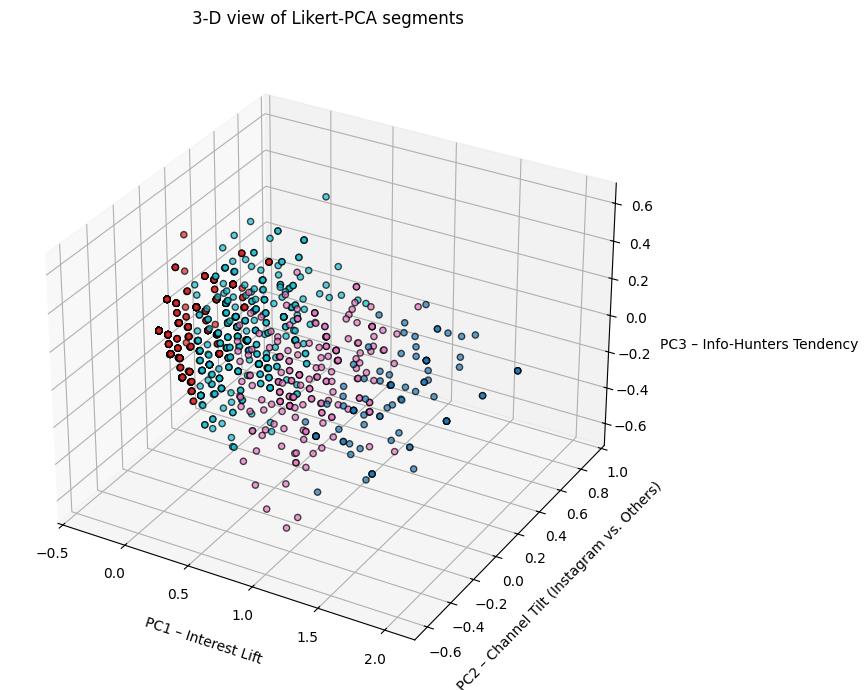

In [7]:
# Cell 5 – 3-D scatter of Likert-PCA segments with PC3 as subtitle
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 – for 3D projection
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure(figsize=(9, 7))
ax  = fig.add_subplot(111, projection='3d')

# discrete colormap based on how many clusters you have
n_clusters = df["cluster"].nunique()
cmap       = cm.get_cmap('tab10', n_clusters)

# map cluster → colour
colors = df["cluster"].map(lambda c: cmap(c))

# 3D scatter
ax.scatter(
    df["PC1"], 
    df["PC2"], 
    df["PC3"],
    c=colors,
    alpha=0.7,
    s=20,
    edgecolor="k"
)

# relabel X/Y axes
ax.set_xlabel("PC1 \u2013 Interest Lift",                       labelpad=10)
ax.set_ylabel("PC2 \u2013 Channel Tilt (Instagram vs. Others)", labelpad=10)

# main title
ax.set_title("3-D view of Likert-PCA segments", pad=15)

# subtitle for PC3
fig.text(
    0.98,   # x position in figure coords
    0.50,   # y position in figure coords
    "PC3 \u2013 Info-Hunters Tendency",
    ha="center", va="center",
    fontsize=10
)

plt.tight_layout()
plt.show()


### Generate Storyline

In [8]:
# 7
# OpenAI-generated storyline  ➜  plus file exports (plots + markdown)
from pathlib import Path
import json, textwrap, inspect
from openai import OpenAI
from IPython.display import Markdown, display

# -----------------------------------------------------------------------
# 0️⃣  Make sure loadings DF exists (creates if Cell 6 wasn’t run)
# -----------------------------------------------------------------------
if "loadings" not in globals():
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=["PC1", "PC2", "PC3"],
        index=likert_feat.columns          # defined in Cell 2b
    )

# -----------------------------------------------------------------------
# 1️⃣  Build JSON blobs for the prompt
# -----------------------------------------------------------------------
variance_dict = dict(zip(["PC1","PC2","PC3"],
                         pca.explained_variance_ratio_.round(3).tolist()))
var_json = json.dumps(variance_dict, indent=2)

loadings_dict = {}
for pc in ["PC1", "PC2", "PC3"]:
    col = loadings[pc]
    loadings_dict[pc] = {
        "top_positive": col.nlargest(5).round(3).to_dict(),
        "top_negative": col.nsmallest(5).round(3).to_dict()
    }
load_json = json.dumps(loadings_dict, indent=2)

cluster_sizes = df["cluster"].value_counts().sort_index().to_dict()
cluster_json  = json.dumps(cluster_sizes, indent=2)

# -----------------------------------------------------------------------
# 2️⃣  Craft the prompt (add Business Impact bullet)
# -----------------------------------------------------------------------
axis_names = {
    "PC1": "Overall Satisfaction",
    "PC2": "Engagement Level",
    "PC3": "Emotional Connection"
}

prompt_text = textwrap.dedent(f"""
    We ran a PCA on a 30-item Likert survey (n = {df.shape[0]}). Below are the
    **PC1–PC3** results and the 4-cluster segmentation created in PC space.

    ### PCA Loadings (top ±5)
    ```json
    {load_json}
    ```

    ### Explained Variance (PC1–PC3)
    ```json
    {var_json}
    ```

    ### Cluster Sizes (k = 4)
    ```json
    {cluster_json}
    ```

    **Tasks (Markdown output, ≤ 350 words)**  
    1. Data overview.  
    2. Pre-processing steps.  
    3. Interpret PC1–PC3 using these axis names → {json.dumps(axis_names)}.  
    4. Describe & label each of the four clusters (size + one-line persona).  
    5. Two actionable recommendations per cluster.  
    6. **Business Impact** – quantify why acting on these insights matters (e.g., churn reduction, upsell growth).  
""")

# -----------------------------------------------------------------------
# 3️⃣  Call OpenAI
# -----------------------------------------------------------------------
client = OpenAI(api_key=keys.api_key)          # keys.api_key set in Cell 0

resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt_text}],
    temperature=0.6
)
story_md = resp.choices[0].message.content.strip()

# -----------------------------------------------------------------------
# 4️⃣  Save deliverables
# -----------------------------------------------------------------------
OUT_DIR = Path("Task2_output")
OUT_DIR.mkdir(exist_ok=True)

md_path = OUT_DIR / "Task2_storyline.md"
md_path.write_text(story_md, encoding="utf-8")

# 2-D & 3-D plot handles – fall back to current figure if vars not captured
fig_2d = globals().get("fig_2d", None) or plt.gcf()
fig_2d.savefig(OUT_DIR / "pc_space_2d.png", dpi=300, bbox_inches="tight")

fig_3d = globals().get("fig_3d", None)
if fig_3d is None:
    # if we used Matplotlib fallback, last 3-D fig is still current
    fig_3d = plt.gcf()
fig_3d.savefig(OUT_DIR / "pc_space_3d.png", dpi=300, bbox_inches="tight")

print(f"✔️  Markdown saved to {md_path}")
print("✔️  Plots saved to Task2_output/pc_space_2d.png and pc_space_3d.png")

# -----------------------------------------------------------------------
# 5️⃣  Preview storyline inline
# -----------------------------------------------------------------------


✔️  Markdown saved to Task2_output\Task2_storyline.md
✔️  Plots saved to Task2_output/pc_space_2d.png and pc_space_3d.png


<Figure size 640x480 with 0 Axes>